# Feature engineering, xgboost
https://www.kaggle.com/dlarionov/feature-engineering-xgboost


-　DateNum作成 'date_block_num',→YYYYMMで代用
- 祝日フラグ
- month
- days
- アイテムカテゴリ（デフォルト)-> カテゴリCategory、ジャンルType
- 月の売り上げ
- 月の売り上げラグ 1,2,3,6,12
- アイテムあたりの「週Or日」平均販売個数 1,2,3,6,12　　'date_item_avg_item_cnt_lag_1',
- ショップあたり「週Or日」平均販売個数ラグ1，2，3，6，12　　'date_shop_avg_item_cnt_lag_1',
- アイテムカテゴリあたり「週Or日」平均販売個数ラグ1,2,3,6,12'date_cat_avg_item_cnt_lag_1',
- カテゴリあたり「週Or日」平均販売個数ラグ1,2,3,6,12，'date_cat_avg_item_cnt_lag_1',
- ジャンル　あたり[月] 平均販売個数ラグ1,2,3,6,12
- アイテムカテゴリ/ショップあたり[月] 平均販売個数ラグ1,2,3,6,12
- カテゴリ/ショップあたり[月] 平均販売個数ラグ1,2,3,6,12
- ジャンル/ショップ　あたり[月] 平均販売個数ラグ1,2,3,6,12
- ASP　月当たり
- 価格下落率
- 最終販売日
- 初販売日
- ショップあたりの最終販売日
- ショップあたりの初販売日
    'delta_price_lag',


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
category_names = pd.read_csv('category_names.csv')
category_names.columns = ['ItemCategoryId', 'ItemCategoryName']

item_categories = pd.read_csv('item_categories.csv')
item_categories.columns = ['ItemId', 'ItemCategoryId']

sales_history = pd.read_csv('sales_history.csv')
sales_history.columns = ['Date', 'StoreId', 'ItemId', 'ItemPrice', 'SoldNum']
sales_history['Date'] = pd.to_datetime(sales_history['Date'])

test = pd.read_csv('test.csv')
test.columns = ['index', 'ItemId', 'StoreId']
#item_categories['ItemCategoryId'].unique()
#category_names.query('ItemCategoryName.str.contains("")')
'''170品目のリスト'''
test_item = test['ItemId'].unique()
test_item = pd.DataFrame({'ItemId':test_item})

'''年月のリスト'''
yyyymm = pd.read_csv('./csv/yyyymm.csv')

'''170品目と月番号加工済みデータ '''
target = pd.read_csv('./csv/sales_170_date_block.csv')

#test_item
'''カテゴリ名と連結'''
ttest = pd.merge(test,item_categories, on='ItemId')
ttest = pd.merge(ttest, category_names,on='ItemCategoryId')
print('予測データの品目数: ',ttest['ItemId'].nunique(),'\n',
      '訓練データの品目数: ',sales_history['ItemId'].nunique(),'\n',
      '予測データのカテゴリ数: ',item_categories['ItemCategoryId'].nunique(),'\n',
      '訓練データのカテゴリ数: ',ttest['ItemCategoryId'].nunique(),'\n',
     '売上の総数: ',sales_history['SoldNum'].sum(), '\n',
     '')

予測データの品目数:  170 
 訓練データの品目数:  9040 
 予測データのカテゴリ数:  26 
 訓練データのカテゴリ数:  26 
 売上の総数:  1262869.0 
 


# pivotせずに特徴量作成

In [3]:
target

,YYYYMM,YYYY,MM,StoreId,ItemId,ItemCategoryId,Category,Type,is_holiday,SoldNum,date_block_num
0,201801,2018,1,0,1000001,100,5,1,0,6,0
1,201801,2018,1,0,1000002,100,5,1,0,2,0
2,201801,2018,1,0,1000004,100,5,1,0,1,0
3,201801,2018,1,0,1000005,100,5,1,0,8,0
4,201801,2018,1,0,1000006,100,5,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
25402,201910,2019,10,17,2900075,290,1,22,0,6,21
25403,201910,2019,10,17,3200001,320,4,10,0,1,21
25404,201910,2019,10,17,3200026,320,4,10,0,4,21
25405,201910,2019,10,17,3400001,340,4,9,1,1,21


# Lag関数

In [4]:
def lag_feature(df,lags,col):
    tmp = df[['date_block_num','StoreId','ItemId',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','StoreId','ItemId',col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df,shifted, on=['date_block_num','StoreId','ItemId'],how='left')
    return df

# 売上月次推移

In [5]:
ts = time.time()
matrix = lag_feature(target,[1,2,3,6,12],'SoldNum')
time.time() - ts

0.059023380279541016

# 品目あたりの月平均売上個数

In [6]:
group = matrix.groupby(['date_block_num']).agg({'SoldNum':'mean'})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

In [7]:
matrix = pd.merge(matrix,group,on='date_block_num',how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'],axis=1,inplace=True)

# 店舗あたりの月平均売上個数

In [8]:
group = matrix.groupby(['date_block_num','StoreId']).agg({'SoldNum':'mean'})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','StoreId'],how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'],axis=1,inplace=True)

# アイテムカテゴリあたりの月平均売上個数

In [9]:
group = matrix.groupby(['date_block_num','ItemCategoryId']).agg({'SoldNum':'mean'})
group.columns = ['date_itemcat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','ItemCategoryId'],how='left')
matrix['date_itemcat_avg_item_cnt'] = matrix['date_itemcat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_itemcat_avg_item_cnt')
matrix.drop(['date_itemcat_avg_item_cnt'],axis=1,inplace=True)

# カテゴリあたりの月平均売上個数

In [10]:
group = matrix.groupby(['date_block_num','Category']).agg({'SoldNum':'mean'})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','Category'],how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'],axis=1,inplace=True)

# ジャンルあたりの月平均売上個数

In [11]:
group = matrix.groupby(['date_block_num','Type']).agg({'SoldNum':'mean'})
group.columns = ['date_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','Type'],how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'],axis=1,inplace=True)

# アイテムカテゴリ・ショップあたりの月平均売上個数

In [13]:
group = matrix.groupby(['date_block_num','StoreId','ItemCategoryId']).agg({'SoldNum':'mean'})
group.columns = ['date_shop_itemcat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','StoreId','ItemCategoryId'],how='left')
matrix['date_shop_itemcat_avg_item_cnt'] = matrix['date_shop_itemcat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_shop_itemcat_avg_item_cnt')
matrix.drop(['date_shop_itemcat_avg_item_cnt'],axis=1,inplace=True)

# カテゴリ・ショップあたりの月平均売上個数

In [15]:
group = matrix.groupby(['date_block_num','StoreId','Category']).agg({'SoldNum':'mean'})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','StoreId','Category'],how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'],axis=1,inplace=True)

# ジャンル・ショップあたりの月平均売上個数

In [16]:
group = matrix.groupby(['date_block_num','StoreId','Type']).agg({'SoldNum':'mean'})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group,on=['date_block_num','StoreId','Type'],how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix,[1,2,3,6,12],'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'],axis=1,inplace=True)

In [18]:
matrix.fillna(0)

,YYYYMM,YYYY,MM,StoreId,ItemId,ItemCategoryId,Category,Type,is_holiday,SoldNum,...,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_6,date_shop_cat_avg_item_cnt_lag_12,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_12
0,201801,2018,1,0,1000001,100,5,1,0,6,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0
1,201801,2018,1,0,1000002,100,5,1,0,2,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0
2,201801,2018,1,0,1000004,100,5,1,0,1,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0
3,201801,2018,1,0,1000005,100,5,1,0,8,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0
4,201801,2018,1,0,1000006,100,5,1,0,2,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25402,201910,2019,10,17,2900075,290,1,22,0,6,...,2.039062,0.0,0.0,0.0,0.0,2.00,0.000000,0.000000,0.0,0.0
25403,201910,2019,10,17,3200001,320,4,10,0,1,...,0.000000,2.0,1.5,0.0,2.0,0.00,1.666992,2.333984,0.0,1.0
25404,201910,2019,10,17,3200026,320,4,10,0,4,...,1.500000,2.0,1.5,0.0,0.0,1.50,1.666992,2.333984,0.0,0.0
25405,201910,2019,10,17,3400001,340,4,9,1,1,...,1.500000,0.0,1.5,0.0,2.0,1.25,0.000000,1.000000,0.0,3.0


In [19]:
matrix_corr = matrix.corr()

<AxesSubplot:>

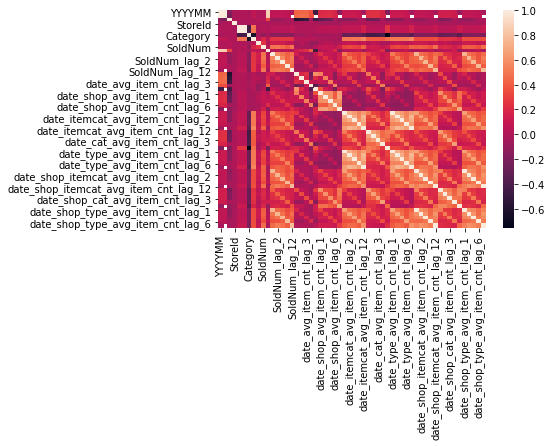

In [20]:
sns.heatmap(matrix_corr)